# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [23]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import sklearn 
from sklearn.model_selection import train_test_split


In [50]:
# Import essential libraries

from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Load the dataset.

In [25]:
# Load and unzip the dataset
zip_path = 'Data.zip'
extract_dir = 'dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    extract_dir,
    image_size=(224, 224),  # Resize to match CNN input
    batch_size=32,
    label_mode='categorical'  # Or 'int' or 'binary' depending on your setup
)

print(train_ds.class_names)


Found 15250 files belonging to 2 classes.
['Data', '__MACOSX']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [26]:
# Create a function to load the raw images


def load_and_preprocess_images(data_dir, image_size=(224, 224)):

    image_data = []
    labels = []
    class_names = sorted([
        name for name in os.listdir(data_dir) 
        if os.path.isdir(os.path.join(data_dir, name)) and not name.startswith('.')
    ])

    for label_index, label_name in enumerate(class_names):
        label_path = os.path.join(data_dir, label_name)
        for image_name in os.listdir(label_path):
            if image_name.startswith('.') or not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue  # Skip system files or unsupported formats

            image_path = os.path.join(label_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img = img.convert("RGB")
                    image_array = np.array(img)
                    image_data.append(image_array)
                    labels.append(label_index)
            except Exception as e:
                print(f"Error loading {image_path}: {e}")

    images_np = np.array(image_data)
    labels_np = np.array(labels)
    return images_np, labels_np, class_names



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [27]:
# Get the images and their labels

images, labels, classes = load_and_preprocess_images('dataset/Data', image_size=(224, 224))
print(f"Loaded {len(images)} images across {len(classes)} categories: {classes}")




Loaded 7625 images across 7 categories: ['Cardboard', 'Foodwaste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


In [28]:
print(f"labels {len(labels)} ")
print(f"classes {classes} ")

labels 7625 
classes ['Cardboard', 'Foodwaste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic'] 


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

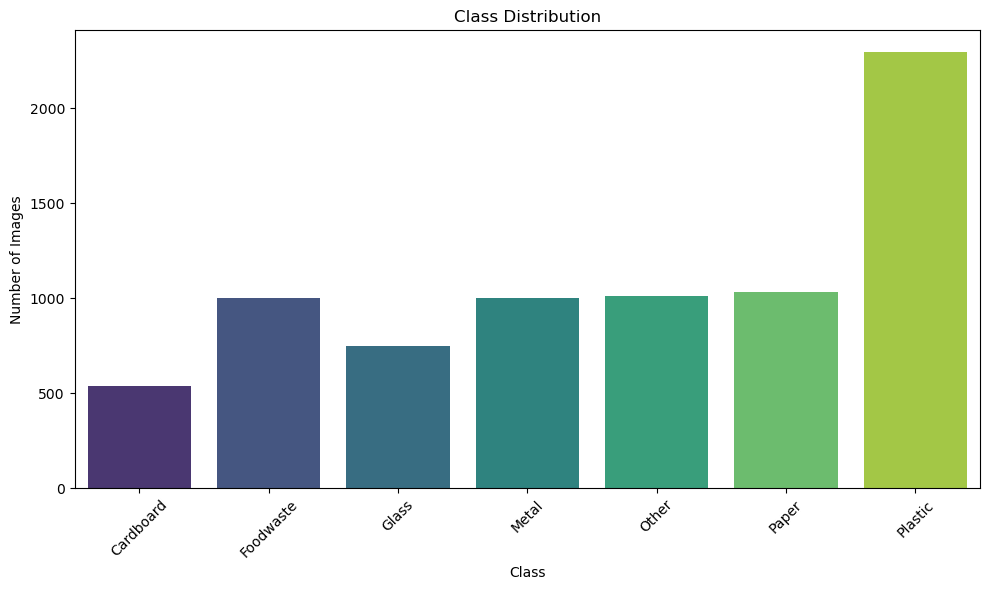

In [29]:
# Visualise Data Distribution

label_counts = Counter(labels)

label_names = [classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=label_names, y=counts, palette='viridis')

plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [30]:
# Visualise Sample Images (across different labels)

def show_sample_images(images, labels, classes, samples_per_class=1):
    plt.figure(figsize=(12, 6))
    shown = 0
    class_seen = set()
    
    for idx in range(len(images)):
        label = labels[idx]
        if label not in class_seen:
            plt.subplot(1, len(classes), shown + 1)
            plt.imshow(images[idx].astype("uint8"))
            plt.title(classes[label])
            plt.axis('off')
            class_seen.add(label)
            shown += 1
        if shown == len(classes):
            break

    plt.tight_layout()
    plt.show()



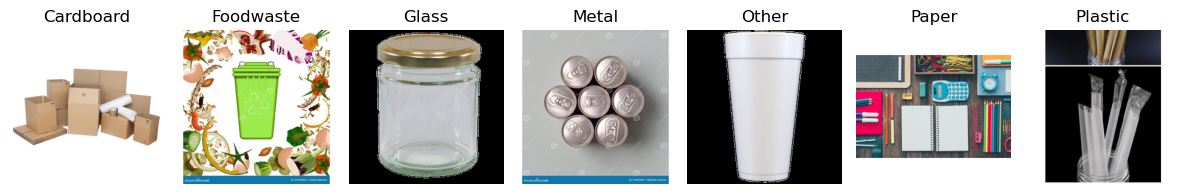

In [31]:
show_sample_images(images, labels, classes)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [32]:
# Find the smallest and largest image dimensions from the data set

def get_image_dimensions(data_dir):
    from PIL import Image
    import os

    min_width, min_height = float('inf'), float('inf')
    max_width, max_height = 0, 0

    for label_name in sorted(os.listdir(data_dir)):
        label_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(label_path):
            continue
        for image_name in os.listdir(label_path):
            if image_name.startswith('.') or not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            image_path = os.path.join(label_path, image_name)
            try:
                with Image.open(image_path) as img:
                    w, h = img.size
                    min_width = min(min_width, w)
                    min_height = min(min_height, h)
                    max_width = max(max_width, w)
                    max_height = max(max_height, h)
            except Exception as e:
                print(f"Failed on {image_path}: {e}")

    return (min_width, min_height), (max_width, max_height)

min_dim, max_dim = get_image_dimensions('dataset/Data')
print(f"Smallest image: {min_dim}")
print(f"Largest image: {max_dim}")


Smallest image: (256, 256)
Largest image: (256, 256)


In [33]:
# Resize the image dimensions

# No need to resize the images as they are in same dimenations

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [35]:
# Encode the labels suitably

# applying one-hot encoding. This transforms your numeric class labels (like 0–6) into a binary matrix format

encoded_labels = to_categorical(labels, num_classes=7)
print(encoded_labels.shape)  # Should be (num_samples, 7)



(7625, 7)


In [38]:
label_index = 2 # assuming label is 2
encoded = to_categorical(label_index, num_classes=7)

# Print the encoded info
print(encoded)


[0. 0. 1. 0. 0. 0. 0.]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [39]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (6100, 256, 256, 3), Validation set: (1525, 256, 256, 3)


In [61]:
from collections import Counter
print(Counter(np.ravel(y_train)))
print(encoded_labels.classes_)


Counter({0.0: 36600, 1.0: 6100})


AttributeError: 'numpy.ndarray' object has no attribute 'classes_'

In [62]:
label_counts = Counter(labels)

# Print with class names
for idx, count in sorted(label_counts.items()):
    print(f"{classes[idx]}: {count}")


Cardboard: 540
Foodwaste: 1000
Glass: 750
Metal: 1000
Other: 1010
Paper: 1030
Plastic: 2295


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [41]:
# Build and compile the model

def build_cnn_model(input_shape=(256, 256, 3), num_classes=7):
    model = Sequential()

    # 1st Convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 2nd Convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.30))

    # 3rd Convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_cnn_model(input_shape=(256, 256, 3), num_classes=7)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      2

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [42]:
# Training

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Save best model to file
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')



In [43]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, model_checkpoint],
    verbose=1
)


Epoch 1/30
191/191 [==============================] - ETA: 0s - loss: 5.3737 - accuracy: 0.2839

/Users/AH66529/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 519s 3s/step - loss: 5.3737 - accuracy: 0.2839 - val_loss: 2.0863 - val_accuracy: 0.2780 - lr: 0.0010
Epoch 2/30
191/191 [==============================] - 859s 5s/step - loss: 1.9050 - accuracy: 0.3020 - val_loss: 2.1471 - val_accuracy: 0.2990 - lr: 0.0010
Epoch 3/30
191/191 [==============================] - 49981s 263s/step - loss: 1.8764 - accuracy: 0.3028 - val_loss: 1.8773 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 4/30
191/191 [==============================] - 565s 3s/step - loss: 1.8593 - accuracy: 0.3025 - val_loss: 1.9428 - val_accuracy: 0.3010 - lr: 0.0010
Epoch 5/30
191/191 [==============================] - 671s 4s/step - loss: 1.8700 - accuracy: 0.3010 - val_loss: 1.8428 - val_accuracy: 0.3023 - lr: 0.0010
Epoch 6/30
191/191 [==============================] - 823s 4s/step - loss: 1.8534 - accuracy: 0.3021 - val_loss: 1.8431 - val_accuracy: 0.3036 - lr: 0.0010
Epoch 7/30
191/191 [==============================] - 827s 4s/step - lo

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [47]:
# Evaluate on the test set; display suitable metrics

y_pred_probs = model.predict(X_val)

y_pred = y_pred_probs.argmax(axis=1)
y_true = y_val.argmax(axis=1)



48/48 [==============================] - 27s 563ms/step


In [48]:
print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

   Cardboard       0.00      0.00      0.00       108
   Foodwaste       0.00      0.00      0.00       200
       Glass       0.00      0.00      0.00       150
       Metal       0.00      0.00      0.00       200
       Other       0.24      0.04      0.08       202
       Paper       0.00      0.00      0.00       206
     Plastic       0.30      0.98      0.46       459

    accuracy                           0.30      1525
   macro avg       0.08      0.15      0.08      1525
weighted avg       0.12      0.30      0.15      1525



/Users/AH66529/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/AH66529/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/AH66529/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


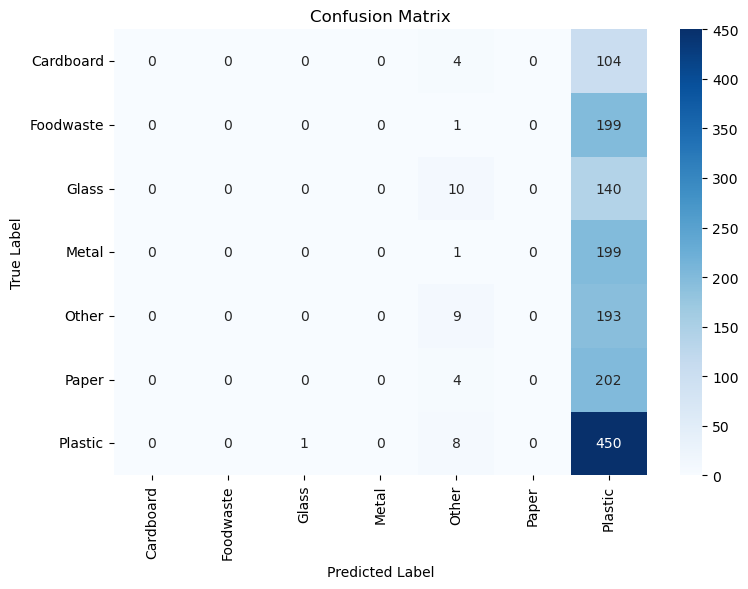

In [51]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


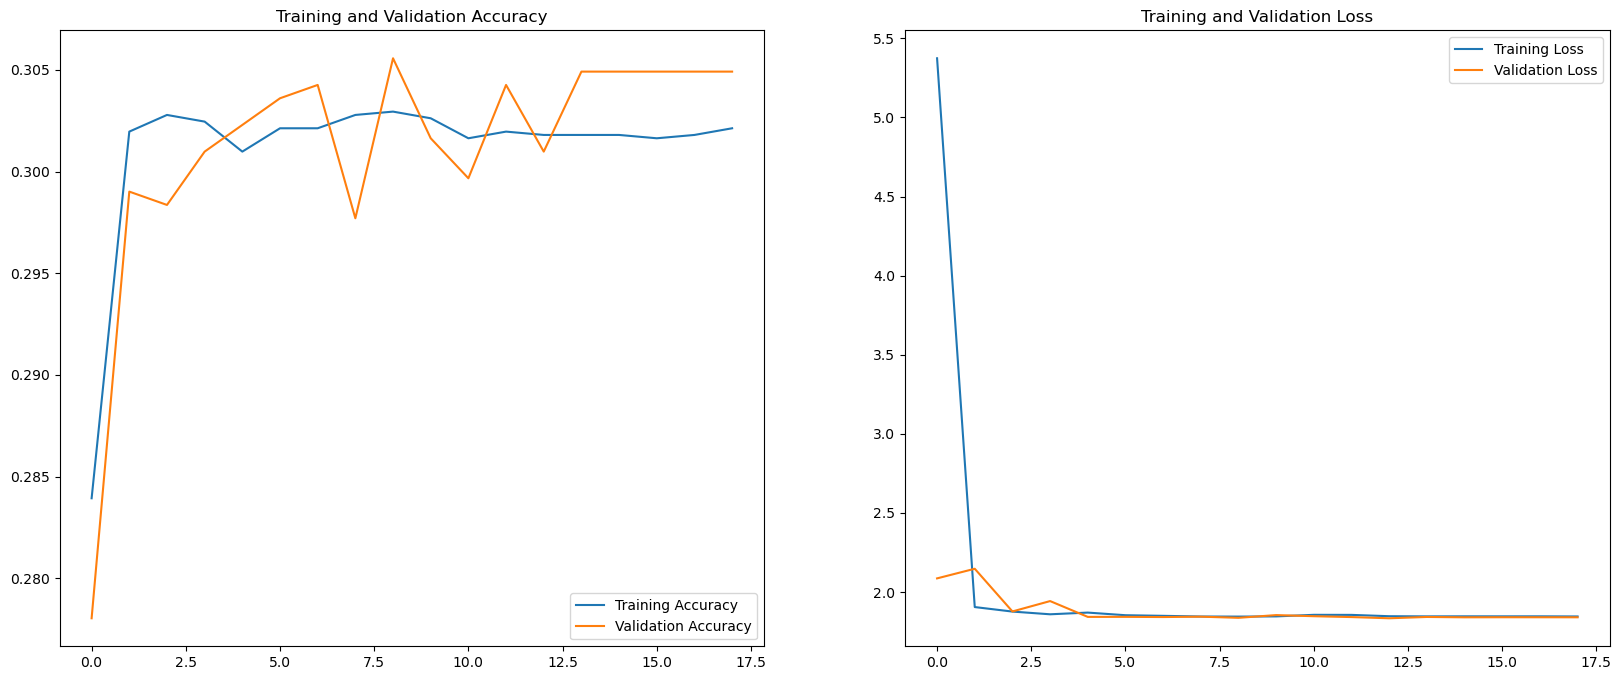

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images




Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

#### Findings about the data

* The dataset has too many images of Plastic (2,295) compared to other materials like Cardboard, Glass, and Foodwaste (only 500–1,000 each).
* Because of this imbalance, the model mostly learns to predict "Plastic", since doing that helps it guess right more often.
* Materials like Cardboard, Glass, and Paper may look similar in the images—they could share colors, textures, or brightness.
* This makes it hard for the model to tell them apart, a problem known as feature overlap.
* The confusion matrix confirms that many non-Plastic items are often wrongly labeled as Plastic.

### Findings about model training results

* Overall accuracy was 30%, meaning the model correctly classified only about 3 out of every 10 test samples.

* Performance on the Plastic class was disproportionately strong:

    * Precision: 0.30

    * Recall: 0.98 — indicating that the model correctly identified almost all instances of Plastic

    * F1-score: 0.46 — reflecting reasonable performance due to extremely high recall

* Performance on all other material classes was poor:

    * Precision, Recall, and F1-score: 0.00 — the model failed to correctly identify any samples of these classes

* ‘Other’ class showed marginal improvement, with an F1-score of 0.08 — still far below acceptable performance levels.

* Macro average F1-score: 0.08 — indicating uniformly low performance across all classes, regardless of their size.

* Weighted average F1-score: 0.15 — heavily influenced by the large number of Plastic samples, despite poor performance elsewhere.

* Confusion matrix highlights widespread misclassification:

    Cardboard → misclassified as Plastic (104) and Paper (4)
    
    Foodwaste → misclassified as Plastic (199) and Paper (1)
    
    Glass → misclassified as Plastic (140) and Paper (10)
    
    Metal → misclassified as Plastic (199) and Paper (1)
    
    Other → misclassified as Plastic (193) and Paper (9)
    
    Paper → misclassified as Plastic (202) and Cardboard (4)
    
    Plastic → occasionally misclassified as Glass (1) and Paper (8), but mostly classified correctly

* he model fails to learn discriminative features for most classes, resulting in poor generalization and boundary formation.

